In [1]:
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
import warnings



In [2]:

df_data= pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv')
df_label=pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv')

# EDA

In [3]:
df_data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


Here the column 'Unnamed: 0' seems to be the primary key, indicating which sample is the row.
We can drop it and instead us the dataframe index.

In [4]:
df_data.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
df_data.head() 

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [6]:
df_label.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


Here the column 'Unnamed: 0' seems to be the primary key, indicating which sample is the row. We can drop it and instead us the dataframe index.

In [7]:
df_label.drop(columns=['Unnamed: 0'],inplace=True)

In [8]:
df_label.head()

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA


Checking for any null values in the dataframe

In [9]:
null_feature=[i for i in df_data.columns if df_data[i].isnull().sum()>=1]
print(null_feature)

[]


In [10]:
null_feature=[i for i in df_label.columns if df_label[i].isnull().sum()>=1]
print(null_feature)

[]


No columns have null data

# PCA

In [15]:
def PCA(df,threshold):
    ## Performing Standardization so that all features are given same importance initially and each feature can contribute
    ## equally to PC irrespective of scale or magnitude
    df =pd.DataFrame(StandardScaler().fit_transform(df))
    ## Performing Data Centering on standardized dataframe
    centred_df= df-np.mean(df,axis=0)
    ## Calculating Covariance 
    covariance=np.cov(df.T)
    eigen_values, eigen_vectors = LA.eig(covariance)
    ## Sorting the eigen values in descending order, using argsort, we get the indices of eigen values in descending order
    sorted_index=eigen_values.argsort()[::-1]
    df_variance=pd.DataFrame(eigen_values[sorted_index]/sum(eigen_values),columns=['variance'])
    df_variance['cumulative_variance']= df_variance['variance'].cumsum()
    ## Number of principal components required to cover variance uptill certian threshold
    df_number_pc_var=df_variance[df_variance['cumulative_variance']<= threshold]
    number_of_pc=len(df_number_pc_var)
    print("The number of principal components required to cover {} percent variance are {}".format(threshold*100,number_of_pc))
    ## Selecting the required number of eigen vectores for performing dot product
    selected_eigen_vectors=eigen_vectors[:,sorted_index[:number_of_pc]]
    
    #Projecting data over the selected number of principal components
    principal_component=centred_df.dot(selected_eigen_vectors) #Performing dot product
    principal_component.columns=[f'PC{i+1}' for i in range(number_of_pc)]
    ## Creating Scree plots
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the first subplot of variance on the left side
    axes[0].plot(range(1,len(df_number_pc_var)+1), df_number_pc_var['variance'],'ro-', linewidth=2)
    axes[0].set_title('Scree Plot for Variance')
    axes[0].set_ylabel('Variance')
    axes[0].set_xlabel('Number of Principal Component')


    # Plot the second subplot of cumulative variance on the right side
    axes[1].plot(range(1,len(df_number_pc_var)+1), df_number_pc_var['cumulative_variance'],'ro-', linewidth=2)
    axes[1].set_title('Scree Plot for Cumulative Variance')
    axes[1].set_ylabel('Cumulative Variance')
    axes[1].set_xlabel('Number of Principal Component')

    plt.show()
    print('Correlation of PC1,PC2 \n',principal_component[['PC1','PC2']].corr())
    plt.scatter(principal_component['PC1'],principal_component['PC2'])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Scatter plot of PC1 VS PC2')
    plt.show()
    print('The Total variance explained by PC1,PC2 is {} percent'.format(round(np.real(df_number_pc_var['cumulative_variance'][1])*100,2)))
    
    loadings = pd.DataFrame(selected_eigen_vectors,index=df.columns)
    warnings.filterwarnings("ignore")
    
    return principal_component,loadings,df_variance,df_number_pc_var,eigen_values, eigen_vectors

The number of principal components required to cover 90.0 percent variance are 372


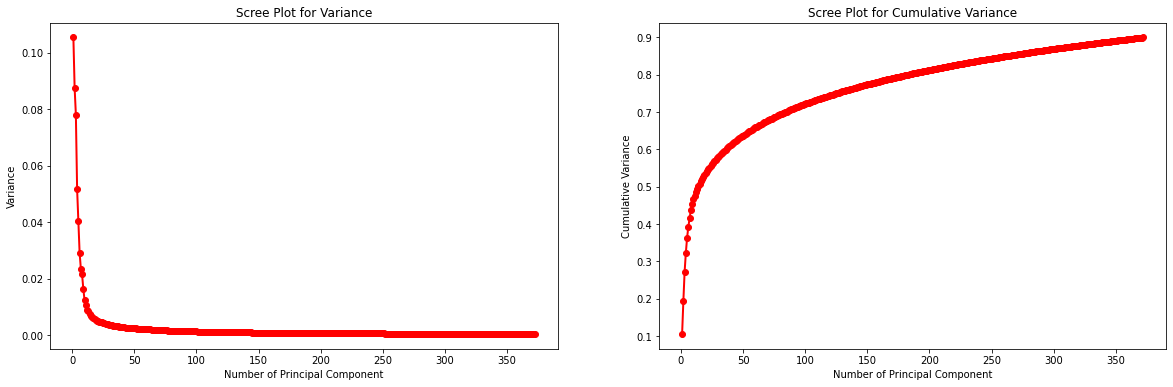

Correlation of PC1,PC2 
               PC1           PC2
PC1  1.000000e+00 -3.620830e-15
PC2 -3.620830e-15  1.000000e+00


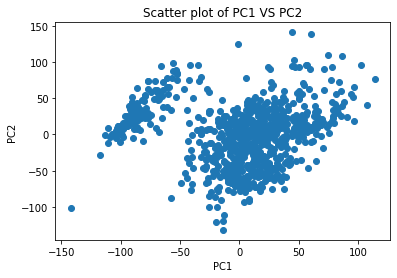

The Total variance explained by PC1,PC2 is 19.29 percent


In [16]:
principal_component,loadings,df_variance,df_number_pc_var,eigen_values, eigen_vectors=PCA(df_data,0.9)


In [ ]:
# principal_component.to_csv('principal_component.csv',index=False)
# loadings.to_csv('loadings.csv',index=False)
# df_variance.to_csv('df_variance.csv',index=False)


In [ ]:
# df_kmeans= pd.DataFrame(np.real(principal_component.values), columns=principal_component.columns)
# df_kmeans.to_csv('principal_component.csv',index=False)

In [17]:
loadings

,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,-0.000979+0.000000j,0.002308+0.000000j,0.000256+0.000000j,-0.000092+0.000000j,0.001215+0.000000j,0.000744+0.000000j,-0.000643+0.000000j,0.001481+0.000000j,0.000479+0.000000j,0.000167+0.000000j,...,0.004653+0.000000j,-0.003130+0.000000j,0.012001+0.000000j,0.010504+0.000000j,-0.013695+0.000000j,0.006706+0.000000j,-0.008466+0.000000j,-0.008070+0.000000j,0.007890+0.000000j,-0.006160+0.000000j
1,0.002356+0.000000j,-0.006373+0.000000j,-0.001453+0.000000j,0.009262+0.000000j,0.013066+0.000000j,0.010121+0.000000j,0.006144+0.000000j,0.011186+0.000000j,0.005241+0.000000j,-0.002569+0.000000j,...,-0.003784+0.000000j,0.006217+0.000000j,0.004670+0.000000j,-0.004547+0.000000j,-0.003102+0.000000j,-0.003555+0.000000j,-0.002322+0.000000j,0.000116+0.000000j,-0.002649+0.000000j,-0.018384+0.000000j
2,0.004966+0.000000j,0.000466+0.000000j,-0.006021+0.000000j,0.005786+0.000000j,0.014661+0.000000j,0.006459+0.000000j,0.004566+0.000000j,0.007997+0.000000j,0.002039+0.000000j,-0.002659+0.000000j,...,-0.004434+0.000000j,0.000460+0.000000j,0.013330+0.000000j,0.000819+0.000000j,0.011121+0.000000j,-0.010255+0.000000j,-0.003141+0.000000j,-0.009287+0.000000j,0.002933+0.000000j,-0.010639+0.000000j
3,0.008465+0.000000j,-0.001566+0.000000j,0.007666+0.000000j,0.010077+0.000000j,0.001393+0.000000j,0.004174+0.000000j,0.008476+0.000000j,-0.010856+0.000000j,0.008076+0.000000j,-0.001170+0.000000j,...,0.002571+0.000000j,0.009086+0.000000j,0.001639+0.000000j,-0.003282+0.000000j,0.003699+0.000000j,-0.001453+0.000000j,-0.007986+0.000000j,0.007039+0.000000j,0.011359+0.000000j,-0.008643+0.000000j
4,0.011697+0.000000j,0.000524+0.000000j,0.003782+0.000000j,-0.006780+0.000000j,-0.008511+0.000000j,-0.014615+0.000000j,0.006949+0.000000j,0.002099+0.000000j,0.006294+0.000000j,0.000091+0.000000j,...,0.005621+0.000000j,-0.002920+0.000000j,0.000351+0.000000j,-0.001773+0.000000j,0.002590+0.000000j,-0.001953+0.000000j,-0.001718+0.000000j,-0.001496+0.000000j,-0.009065+0.000000j,-0.005162+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,-0.000375+0.000000j,0.007708+0.000000j,0.008281+0.000000j,-0.008669+0.000000j,0.004553+0.000000j,0.003759+0.000000j,0.001008+0.000000j,-0.025392+0.000000j,0.002108+0.000000j,-0.006598+0.000000j,...,0.003071+0.000000j,0.000886+0.000000j,-0.005728+0.000000j,-0.003879+0.000000j,-0.005696+0.000000j,0.001692+0.000000j,-0.001831+0.000000j,-0.006455+0.000000j,-0.003133+0.000000j,-0.001024+0.000000j
20527,-0.004694+0.000000j,-0.005735+0.000000j,-0.004342+0.000000j,0.007924+0.000000j,0.008366+0.000000j,0.021337+0.000000j,-0.002341+0.000000j,-0.006093+0.000000j,-0.010695+0.000000j,0.008080+0.000000j,...,-0.003241+0.000000j,0.002187+0.000000j,-0.001440+0.000000j,-0.000551+0.000000j,0.002930+0.000000j,-0.008298+0.000000j,0.004395+0.000000j,-0.005093+0.000000j,-0.009901+0.000000j,0.001626+0.000000j
20528,-0.002337+0.000000j,-0.014940+0.000000j,-0.003002+0.000000j,0.006111+0.000000j,0.001656+0.000000j,-0.004296+0.000000j,0.011469+0.000000j,0.000298+0.000000j,0.002855+0.000000j,0.000413+0.000000j,...,0.003100+0.000000j,0.005628+0.000000j,0.008100+0.000000j,0.004212+0.000000j,0.004357+0.000000j,-0.001686+0.000000j,0.009943+0.000000j,0.008083+0.000000j,-0.011439+0.000000j,-0.001142+0.000000j
20529,-0.001960+0.000000j,-0.002321+0.000000j,-0.007047+0.000000j,-0.009532+0.000000j,0.003486+0.000000j,-0.000249+0.000000j,0.000860+0.000000j,-0.008917+0.000000j,0.000754+0.000000j,-0.011964+0.000000j,...,-0.016986+0.000000j,-0.019563+0.000000j,0.002472+0.000000j,0.001620+0.000000j,-0.008621+0.000000j,0.000074+0.000000j,0.004033+0.000000j,-0.001880+0.000000j,0.006852+0.000000j,0.012233+0.000000j


In [23]:

df_variance_r= pd.DataFrame(np.real(df_variance.values), columns=df_variance.columns)

[84, 91, 98, 106, 115, 124, 134, 145, 157, 169, 182, 196, 211, 226, 243, 261, 281, 301, 323, 347, 372]


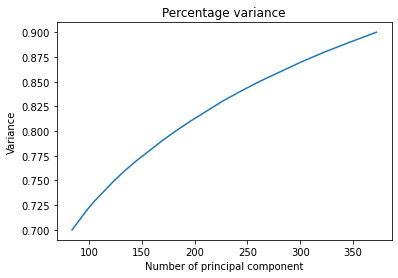

In [32]:
variance_limit=[float(i)/100 for i in range(70,91)]
nom_pc=[]
for i in variance_limit:
    nom_pc.append(len(df_variance_r[df_variance_r['cumulative_variance']<= i]))

print(nom_pc)
plt.plot(nom_pc,variance_limit)
plt.xlabel('Number of principal component')
plt.ylabel('Variance')
plt.title('Percentage variance')
plt.show()

In [29]:
nom_pc

[84,
 91,
 98,
 106,
 115,
 124,
 134,
 145,
 157,
 169,
 182,
 196,
 211,
 226,
 243,
 261,
 281,
 301,
 323,
 347,
 372]

In [35]:
len(df_variance_r[df_variance_r['cumulative_variance']<= 0.999])

790

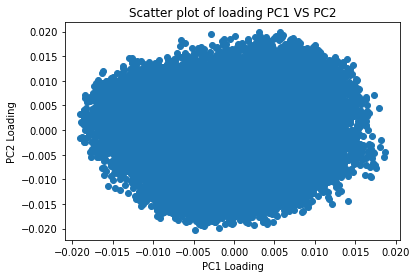

In [40]:

plt.scatter(loadings[0],loadings[1])
plt.xlabel('PC1 Loading')
plt.ylabel('PC2 Loading')
plt.title('Scatter plot of loading PC1 VS PC2')
plt.show()